## Import Libraries

In [1]:
#System access libraries
import os
import sys

#give random numbers - could use numpy here 
import random
import warnings

import numpy as np
import pandas as pd
import cv2 # Python image processing library

import matplotlib.pyplot as plt


from tqdm import tqdm # Allows espace characters
from itertools import chain 
import skimage # Image plotting library out of SKL
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb # Refer to different colour scales
from sklearn.model_selection import train_test_split

# The model we are borrowing
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

# Keras layers to build the model
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

In [2]:
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)
TRAIN_PATH = 'C:/Users/Talal/Desktop/Python/dataset/dataset_updated/training_set/painting/'


train_ids = next(os.walk(TRAIN_PATH))[2]

#train_ids = os.walk(TRAIN_PATH)[2]

In [4]:
train_ids

['0001.jpg',
 '0002.jpg',
 '0003.jpg',
 '0004.jpg',
 '0005.jpg',
 '0007.jpg',
 '0008.jpg',
 '0010.jpg',
 '0011.jpg',
 '0013.jpg',
 '0014.jpg',
 '0015.jpg',
 '0016.jpg',
 '0018.jpg',
 '0019.jpg',
 '0020.jpg',
 '0021.jpg',
 '0022.jpg',
 '0023.jpg',
 '0024.jpg',
 '0026.jpg',
 '0027.jpg',
 '0028.jpg',
 '0029.jpg',
 '0030.jpg',
 '0031.jpg',
 '0032.jpg',
 '0033.jpg',
 '0034.jpg',
 '0035.jpg',
 '0036.jpg',
 '0037.jpg',
 '0038.jpg',
 '0040.jpg',
 '0042.jpg',
 '0043.jpg',
 '0044.jpg',
 '0045.jpg',
 '0046.jpg',
 '0047.jpg',
 '0048.jpg',
 '0049.jpg',
 '0051.jpg',
 '0052.jpg',
 '0053.jpg',
 '0054.jpg',
 '0055.jpg',
 '0056.jpg',
 '0057.jpg',
 '0058.jpg',
 '0059.jpg',
 '0060.jpg',
 '0061.jpg',
 '0062.jpg',
 '0063.jpg',
 '0064.jpg',
 '0065.jpg',
 '0066.jpg',
 '0067.jpg',
 '0068.jpg',
 '0069.jpg',
 '0070.jpg',
 '0071.jpg',
 '0072.jpg',
 '0073.jpg',
 '0074.jpg',
 '0076.jpg',
 '0077.jpg',
 '0078.jpg',
 '0079.jpg',
 '0081.jpg',
 '0082.jpg',
 '0083.jpg',
 '0084.jpg',
 '0085.jpg',
 '0086.jpg',
 '0087.jpg',

In [5]:
%%time

X_train = np.zeros((len(train_ids)-86, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
missing_count = 0


print('Getting train images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_+''
    try:
        img = skimage.io.imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n-missing_count] = img
    except:
        missing_count += 1

X_train = X_train.astype('float32') / 255.
print("Total missing: "+ str(missing_count))

Getting train images ... 


100%|██████████| 2042/2042 [00:28<00:00, 71.90it/s]


Total missing: 86
CPU times: total: 29.1 s
Wall time: 29.1 s


In [6]:
# Reserve 20 images for the test set
x_train, x_test = train_test_split(X_train, test_size = 20, random_state=seed)

In [7]:
#The weights are available on GitHub: https://github.com/fchollet/deep-learning-models/releases/
tf.compat.v1.disable_eager_execution()

inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.compat.v1.get_default_graph()

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
def Colorize():
    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [9]:
from keras.models import Sequential

model = Colorize()
model.compile(optimizer='adam', loss='mean_squared_error', run_eagerly=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 256, 256, 12  1280        ['input_3[0][0]']                
                                8)                                                                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 12  0          ['conv2d_203[0][0]']             
                                8)                                                            

In [10]:
%%time

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Create embedding
def create_inception_embedding(grayscaled_rgb):
    def resize_gray(x):
        return resize(x, (299, 299, 3), mode='constant')
    grayscaled_rgb_resized = np.array([resize_gray(x) for x in grayscaled_rgb])
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

#Generate training data
def image_a_b_gen(dataset=x_train, batch_size = 20):
    for batch in datagen.flow(dataset, batch_size=batch_size):
        X_batch = rgb2gray(batch)
        grayscaled_rgb = gray2rgb(X_batch)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield [X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch

CPU times: total: 0 ns
Wall time: 0 ns


In [11]:
model = Colorize()
model.load_weights('Art_Colorization_Weights.h5')

In [12]:
sample = x_test
color_me = gray2rgb(rgb2gray(sample))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = model.predict([color_me, color_me_embed])
output = output * 128

decoded_imgs = np.zeros((len(output),256, 256, 3))

for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    decoded_imgs[i] = lab2rgb(cur)
    cv2.imwrite("img_"+str(i)+".jpg", lab2rgb(cur)*255.0)

D:\Anaconda\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


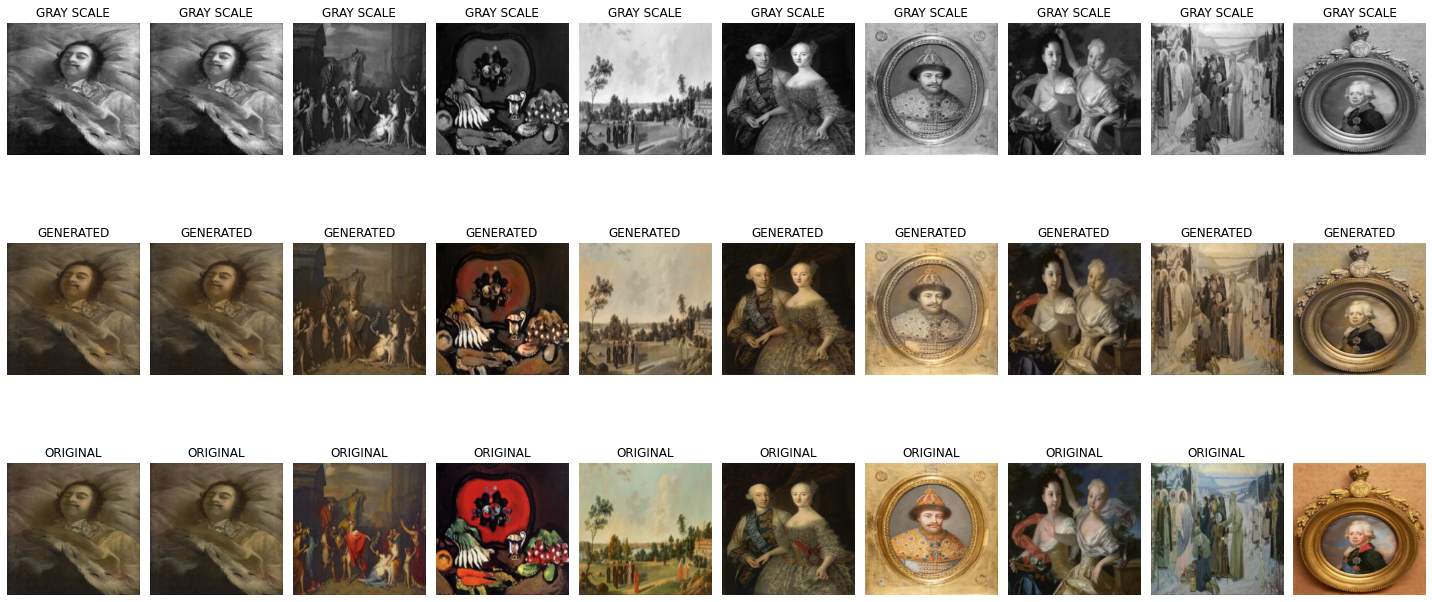

In [13]:
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.title("ORIGINAL")
    
    #Greyscale Images
    plt.subplot(3, 10, i + 1)
    plt.imshow(rgb2gray(x_test)[i].reshape(256, 256))
    plt.gray()
    plt.axis('off')
    plt.title("GRAY SCALE")
   
    #Prediction
    plt.subplot(3, 10, i + 1 +10)
    plt.imshow(decoded_imgs[i].reshape(256, 256,3))
    plt.axis('off')
    plt.title("GENERATED")
    
    # Original
    plt.subplot(3, 10, i + 1 + 20)
    plt.imshow(x_test[i].reshape(256, 256,3))
    plt.axis('off')
 
plt.tight_layout()
plt.show()

## Coloring the image

In [17]:
X_test = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
img = imread('sure.jpg')
img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True)
print(img.shape)

#img = cv2.merge((img,img,img)) #Add the grey values to 3 layers instead of 1
#print(img.shape)

(256, 256, 3)


In [18]:
X_test[0]= img
X_test = X_test.astype('float32')/255

In [19]:
sample = X_test
color_me = gray2rgb(rgb2gray(sample))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = model.predict([color_me, color_me_embed])
output = output * 128

decoded_imgs = np.zeros((len(output),256, 256, 3))

for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    decoded_imgs[i] = lab2rgb(cur)
    cv2.imwrite("img_"+str(i)+".jpg", lab2rgb(cur))

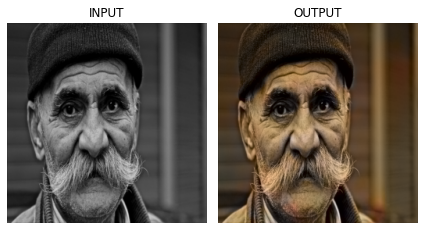

In [20]:
plt.title("RESULTS")
plt.axis('off')

plt.subplot(1,2,1)
plt.imshow(X_test[0])
plt.gray()
plt.axis('off')
# recolorization
plt.title("INPUT")

plt.subplot(1,2,2)
plt.imshow(decoded_imgs[0].reshape(256, 256,3))
plt.axis('off')
plt.title("OUTPUT")

plt.tight_layout()
plt.show()